In [132]:
# !/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on 20180410

@author: zhangji
"""

%pylab inline
pylab.rcParams['figure.figsize'] = (18.5, 10.5)
fontsize = 40

import os
import importlib
import numpy as np
import scipy as sp
import pandas as pd
import re
from scanf import scanf
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
from scipy.interpolate import interp1d
from IPython.display import display, HTML
from scipy import interpolate, integrate, optimize
from codeStore import support_fun as spf
from src import slenderBodyTheory as slb
from src import stokesletsInPipe as stlpp
from src import stokes_flow as sf
from src import geo
from tqdm.notebook import tqdm as tqdm_notebook

PWD = os.getcwd()
np.set_printoptions(linewidth=130, precision=5)

Populating the interactive namespace from numpy and matplotlib


In [35]:
importlib.reload(stlpp)
greenFun = stlpp.StokesletsRinginPipe_light(threshold=1000)
greenFun.solve_prepare_light()

True

In [53]:
greenFun.set_b(b=0.1)
greenFun.solve_prepare_b()
mij = greenFun.solve_u_light(0.2, 0.2)

R = 0.1
z_list = np.linspace(0, 1e1, 100)
tu = []
for zi in z_list:
    tu.append(greenFun.solve_u1_light(0.1, zi))
tu = np.array(tu)

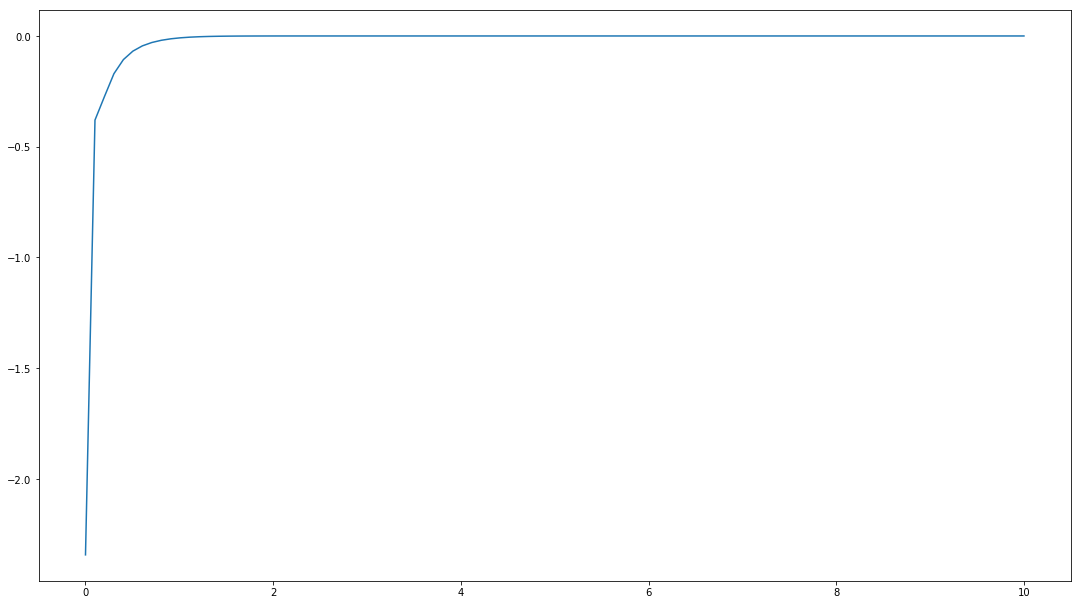

In [54]:
plt.plot(z_list, tu[:, 2])

0.0 0.0


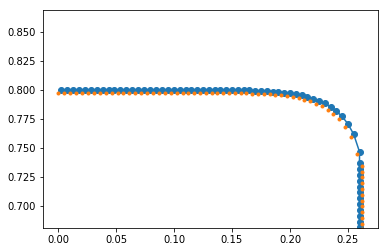

In [174]:
importlib.reload(geo)
importlib.reload(sf)

length = 0.2
rh = 0.8
deltalength = 0.005

u_geo = geo.revolve_pipe()
# f_geo = u_geo.create_deltalength(deltalength, length, rh)
f_geo = u_geo.create_half_deltalength_v2(deltalength, length, rh)
t1 = u_geo.get_nodes()

# f_geo = u_geo.copy()
# f_geo.node_zoom((length - deltalength) / length)
t2 = f_geo.get_nodes()

plt.plot(t1[:, 2], t1[:, 0], '-o')
plt.plot(t2[:, 2], t2[:, 0], '.')
# plt.plot(t1[:, 2], np.ones_like(t1[:, 2]) * t1[-1, 0], '-o')
# plt.plot(t2[:, 2], np.ones_like(t1[:, 2]) * t2[-1, 0], '.')
plt.gca().axis('equal')
plt.ylim(rh - 0.1, rh + 0.05)
print(t1.min(), t1.min())
# print(t1[:, [0, 2]][:])

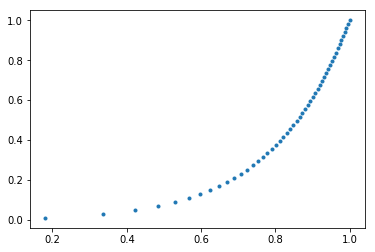

In [117]:
n = 100
factor = 0.1

f1 = lambda x: (np.exp(x * factor) - 1) / (2 * (np.exp(0.5 * factor) - 1))
f2 = lambda x: np.log(2 * (np.exp(0.5 / factor) - 1) * x + 1) * factor
x = np.linspace(-0.5, 0.5, n)
y1 = np.sign(x) * f1(np.abs(x)) + 0.5
y2 = np.sign(x) * f2(np.abs(x)) + 0.5
y = (y1 * factor + y2 / factor) / (y1[-1] * factor + y2[-1] / factor)
x = x * 2
y = y * 2 - 1

plt.plot(y[int(n/2):], x[int(n/2):], '.')

(-1.045, 1.045, 0.27792493402732055, 1.0330741836645083)

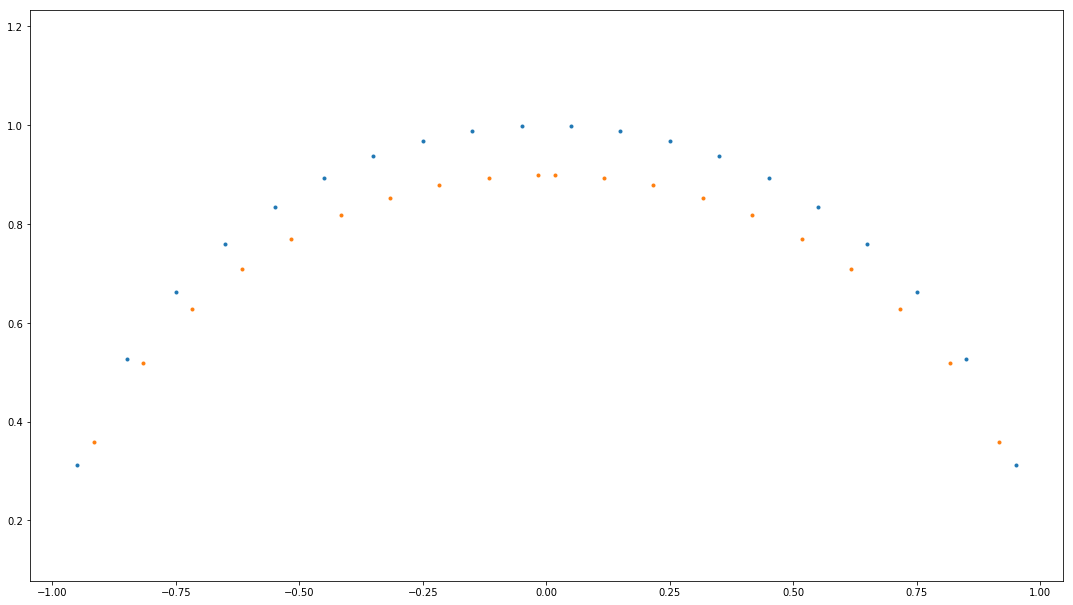

In [142]:
importlib.reload(geo)
importlib.reload(sf)

a = 1
b = 1
deltalength = 0.05
kwargs = {}

u_geo = geo.revolve_ellipse()
f_geo = u_geo.create_deltalength(deltalength, a, b)
t1 = u_geo.get_nodes()
afct = (a - deltalength) / a
bfct = (b - deltalength) / b
t2 = f_geo.get_nodes()

plt.plot(t1[:, 2], t1[:, 0], '.')
plt.plot(t2[:, 2], t2[:, 0], '.')
plt.gca().axis('equal')


## calculate and show

In [1]:
import sys
import petsc4py
petsc4py.init(sys.argv)
import numpy as np
from matplotlib import pyplot as plt
import importlib

# from time import time
# from scipy.io import loadmat
# from src.stokes_flow import problem_dic, obj_dic
from src import geo
from petsc4py import PETSc
from src import stokes_flow as sf
from src.myio import *
from src.support_class import *
from src.objComposite import createEcoliComp_tunnel
from src.myvtk import save_singleEcoli_vtk
from ecoli_in_pipe.ecoli_common import *
np.set_printoptions(linewidth=300)

In [4]:
importlib.reload(sf)
importlib.reload(geo)
rs1 = 0.6
rs2 = 0.6
ls = 1
ds = 0.01
stokeslets_threshold = 100
ksp_max_it = 1000
use_tqdm_notebook = True

matrix_method = 'pf_stokesletsRingInPipe'
OptDB = PETSc.Options()
fileHandle = OptDB.getString('f', 'try_stokesletsRingInPipe')
OptDB.setValue('f', fileHandle)
OptDB.setValue('sm', matrix_method)
main_kwargs = {'fileHandle': fileHandle}
problem_kwargs = get_problem_kwargs(**main_kwargs)
problem_kwargs['rs1'] = rs1
problem_kwargs['rs2'] = rs2
problem_kwargs['ls'] = ls
problem_kwargs['ds'] = ds
problem_kwargs['ksp_max_it'] = ksp_max_it
problem_kwargs['use_tqdm_notebook'] = use_tqdm_notebook
problem_kwargs['stokeslets_threshold'] = stokeslets_threshold
if not problem_kwargs['restart']:
    print_case_info(**problem_kwargs)

#     # sphere
#     rs1 = problem_kwargs['rs1']
#     rs2 = problem_kwargs['rs2']
#     ds = problem_kwargs['ds']
#     u_geo = geo.revolve_ellipse()
#     f_geo = u_geo.create_deltalength(ds, rs1, rs2)
#     u_geo.set_rigid_velocity(np.array((0, 0, 1, 0, 0, 0)))
    
    # cylinder
    rs = problem_kwargs['rs1']
    ls = problem_kwargs['ls']
    ds = problem_kwargs['ds']
    u_geo = geo.revolve_pipe()
    f_geo = u_geo.create_deltalength(ds, ls, rs)
    u_geo.set_rigid_velocity(np.array((0, 0, 1, 0, 0, 0)))
    
    revolve_obj1 = sf.StokesFlowObj()
    revolve_obj1.set_data(f_geo, u_geo, name='sphereObj_0')    
    problem1 = sf.StokesletsRingInPipeProblem(**problem_kwargs)
    problem1.do_solve_process((revolve_obj1,), pick_M=False)
    print(revolve_obj1.get_total_force()[:3] * 2 * np.pi / (6 * np.pi * rs2))

matrix_method = 'pf_stokesletsRingInPipeProblemSymz'
OptDB = PETSc.Options()
fileHandle = OptDB.getString('f', 'try_stokesletsRingInPipe')
OptDB.setValue('f', fileHandle)
OptDB.setValue('sm', matrix_method)
main_kwargs = {'fileHandle': fileHandle}
problem_kwargs = get_problem_kwargs(**main_kwargs)
problem_kwargs['rs1'] = rs1
problem_kwargs['rs2'] = rs2
problem_kwargs['ls'] = ls
problem_kwargs['ds'] = ds
problem_kwargs['ksp_max_it'] = ksp_max_it
problem_kwargs['use_tqdm_notebook'] = use_tqdm_notebook
problem_kwargs['stokeslets_threshold'] = stokeslets_threshold
if not problem_kwargs['restart']:
    print_case_info(**problem_kwargs)

#     # sphere
#     rs1 = problem_kwargs['rs1']
#     rs2 = problem_kwargs['rs2']
#     ds = problem_kwargs['ds']
#     u_geo = geo.revolve_ellipse()
#     f_geo = u_geo.create_half_deltalength(ds, rs1, rs2)
#     u_geo.set_rigid_velocity(np.array((0, 0, 1, 0, 0, 0)))

    # cylinder
    rs = problem_kwargs['rs1']
    ls = problem_kwargs['ls']
    ds = problem_kwargs['ds']
    u_geo = geo.revolve_pipe()
    f_geo = u_geo.create_half_deltalength(ds, ls, rs)
    u_geo.set_rigid_velocity(np.array((0, 0, 1, 0, 0, 0)))
    
    revolve_obj2 = sf.StokesFlowObj()
    revolve_obj2.set_data(f_geo, u_geo, name='sphereObj_0')    
    problem2 = sf.StokesletsRingInPipeProblemSymz(**problem_kwargs)
    problem2.do_solve_process((revolve_obj2,), pick_M=False)
    print(revolve_obj2.get_total_force()[:3] * 2 * np.pi / (6 * np.pi * rs2) * 2)


[-6.02540682e-03  0.00000000e+00  2.09295651e+01]



[4.91397560e+05 0.00000000e+00 2.07069045e+01]


(0, 1)

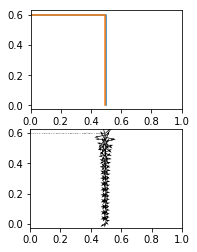

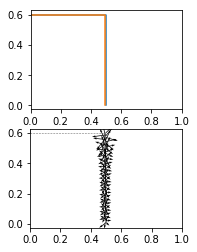

In [8]:
%matplotlib inline
tfct = 0.0031
n_nodes = revolve_obj1.get_f_nodes().shape[0]
tf = revolve_obj1.get_force().reshape((-1, 3)).T[:, :int(n_nodes/2)]
tu = revolve_obj1.get_velocity().reshape((-1, 3)).T[:, :int(n_nodes/2)]
tfn = revolve_obj1.get_f_nodes().T[:, :int(n_nodes/2)]
tun = revolve_obj1.get_u_nodes().T[:, :int(n_nodes/2)]

fig, axs = plt.subplots(nrows=2, ncols=1)
fig.patch.set_facecolor('white')
axi = axs[0]
axi.plot(tun[2], tun[0])
axi.plot(tfn[2], tfn[0])
axi.set_aspect('equal', 'box')
axi.set_xlim(0, 1)
axi = axs[1]
axi.quiver(tfn[2], tfn[0], tf[2]*tfct, tf[0]*tfct, scale = 1., units='width')
axi.set_aspect('equal', 'box')
axi.set_xlim(0, 1)

tf = revolve_obj2.get_force().reshape((-1, 3)).T
tu = revolve_obj2.get_velocity().reshape((-1, 3)).T
tfn = revolve_obj2.get_f_nodes().T
tun = revolve_obj2.get_u_nodes().T

fig, axs = plt.subplots(nrows=2, ncols=1)
fig.patch.set_facecolor('white')
axi = axs[0]
axi.plot(tun[2], tun[0])
axi.plot(tfn[2], tfn[0])
axi.set_aspect('equal', 'box')
axi.set_xlim(0, 1)
axi = axs[1]
axi.quiver(tfn[2], tfn[0], tf[2]*tfct, tf[0]*tfct, scale = 1., units='width')
axi.set_aspect('equal', 'box')
axi.set_xlim(0, 1)

## This version assume an aditional symmetric along z axis. 

In [2]:
importlib.reload(sf)
importlib.reload(geo)
rs1 = 0.5
rs2 = 0.5
ls = 1
ds = 0.01
stokeslets_threshold = 100
ksp_max_it = 1000
use_tqdm_notebook = True
matrix_method = 'pf_stokesletsRingInPipeProblemSymz'

OptDB = PETSc.Options()
fileHandle = OptDB.getString('f', 'try_stokesletsRingInPipe')
OptDB.setValue('f', fileHandle)
OptDB.setValue('sm', matrix_method)
main_kwargs = {'fileHandle': fileHandle}
problem_kwargs = get_problem_kwargs(**main_kwargs)
problem_kwargs['rs1'] = rs1
problem_kwargs['rs2'] = rs2
problem_kwargs['ls'] = ls
problem_kwargs['ds'] = ds
problem_kwargs['ksp_max_it'] = ksp_max_it
problem_kwargs['use_tqdm_notebook'] = use_tqdm_notebook
problem_kwargs['stokeslets_threshold'] = stokeslets_threshold

if not problem_kwargs['restart']:
    print_case_info(**problem_kwargs)
    # cylinder
    rs = problem_kwargs['rs1']
    ls = problem_kwargs['ls']
    ds = problem_kwargs['ds']
    u_geo = geo.revolve_pipe()
    f_geo = u_geo.create_half_deltalength(ds, ls, rs)
#     u_geo.set_rigid_velocity(np.array((0, 0, 1, 0, 0, 0)))
    u_geo.set_rigid_velocity(np.array((0, 0, 0, 0, 0, 1)))
    
    revolve_obj2 = sf.StokesFlowObj()
    revolve_obj2.set_data(f_geo, u_geo, name='sphereObj_0')    
    problem2 = sf.StokesletsRingInPipeProblemSymz(**problem_kwargs)
    problem2.do_solve_process((revolve_obj2,), pick_M=False)
    print(revolve_obj2.get_total_force()[:3] * 2 * np.pi / (6 * np.pi * rs2) * 2)
    print(revolve_obj2.get_total_force()[3:] * 2 * np.pi / (8 * np.pi * rs2 ** 2) * 2)


[0.         7.39136016 0.        ]
[-5.15092443  0.          0.96209312]


In [33]:
m2 = problem2.get_M()
tun2 = revolve_obj2.get_u_nodes().T
tfn2 = revolve_obj2.get_f_nodes().T
tf2 = revolve_obj2.get_force()
tu2 = revolve_obj2.get_velocity()

(0, 1)

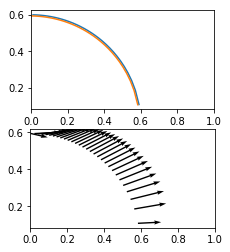

In [34]:
%matplotlib inline
tfct = 0.5
tf = revolve_obj2.get_force().reshape((-1, 3)).T
tu = revolve_obj2.get_velocity().reshape((-1, 3)).T
tfn = revolve_obj2.get_f_nodes().T
tun = revolve_obj2.get_u_nodes().T

fig, axs = plt.subplots(nrows=2, ncols=1)
fig.patch.set_facecolor('white')
axi = axs[0]
axi.plot(tun[2], tun[0])
axi.plot(tfn[2], tfn[0])
axi.set_aspect('equal', 'box')
axi.set_xlim(0, 1)
axi = axs[1]
axi.quiver(tfn[2], tfn[0], tf[2]*tfct, tf[0]*tfct, scale = 1., units='width')
axi.set_aspect('equal', 'box')
axi.set_xlim(0, 1)

In [11]:
print(revolve_obj2.get_total_force()[:] * 2 * np.pi / (6 * np.pi * rs2) * 2)

[ 2.46646546e+06  0.00000000e+00  5.45125819e+01  0.00000000e+00 -4.46999724e+02  0.00000000e+00]


## Stokeslets Ring in bulk fluid

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from src.geo import *
from petsc4py import PETSc
from src import stokes_flow as sf
from codeStore.ecoli_common import *
from matplotlib import pyplot as plt


In [10]:
problem_kwargs = {'rs1':                   1.0,
                  'ch':                    0.1,
                  'ffweightz':             1,
                  'rh12':                  0.2,
                  'bnodeshandle':          'bnodes',
                  'with_T_geo':            True,
                  'n_node_threshold':      10000,
                  'rs2':                   1.0,
                  'eT':                    -0.1,
                  'pickProblem':           False,
                  'rh2':                   0.05,
                  'rot_norm':              np.array([1, 0, 0]),
                  'fileHandle':            'dbg',
                  'rT2':                   0.05,
                  'precondition_method':   'none',
                  'hfct':                  1,
                  'rh1':                   0.2,
                  'restart':               False,
                  'with_cover':            2,
                  'zoom_factor':           1,
                  'ds':                    0.1,
                  'rh11':                  0.2,
                  'rel_Us':                np.array([0., 0., 0., 0., 0., 0.]),
                  'ntT':                   3,
                  'n_tail':                2,
                  'Tfct':                  1,
                  'solve_method':          'gmres',
                  'ls':                    4.0,
                  'center':                np.array([0, 0, 0]),
                  'getConvergenceHistory': False,
                  'ffweightT':             1,
                  'MPISIZE':               1,
                  'dist_hs':               2,
                  'eh':                    -0.1,
                  'matrix_method':         'pf_stokesletsRing',
                  'int_limit':             10000,
                  'int_epsabs':            1e-200,
                  'rT1':                   0.2,
                  'es':                    -1.0,
                  'ffweighty':             1,
                  'matname':               'body1',
                  'int_epsrel':            1e-10,
                  'belemshandle':          'belems',
                  'rot_theta':             0,
                  'ph':                    3,
                  'left_hand':             False,
                  'plot_geo':              False,
                  'nth':                   3,
                  'rel_Uh':                np.array([0., 0., 0., 0., 0., 0.]),
                  'ffweightx':             1}
problem_kwargs['ls'] = 4

fileHandle = problem_kwargs['fileHandle']
print_case_info(**problem_kwargs)
# cylinder in bulk fluid
rs1 = problem_kwargs['rs1']
rs2 = problem_kwargs['rs2']
err_msg = 'the symmetric assumption needs rs1==rs2'
assert rs1 == rs2, err_msg
ls = problem_kwargs['ls']
ds = problem_kwargs['ds']
u_geo = revolve_pipe()
f_geo = u_geo.create_deltaz(ds, ls, rs1)
u_geo.set_rigid_velocity(np.array((0, 0, 1, 0, 0, 0)))
revolve_obj = sf.StokesFlowRingObj()
revolve_obj.set_data(f_geo, u_geo, name='pipeObj_0')
problem = sf.StokesletsRingProblem(**problem_kwargs)

problem.add_obj(revolve_obj)
if problem_kwargs['pickProblem']:
    problem.pickmyself('%s_tran' % fileHandle, ifcheck=True)
problem.print_info()
problem.create_matrix()

# translation
revolve_obj.set_rigid_velocity(np.array((0, 0, 1, 0, 0, 0)))
problem.create_F_U()
problem.solve()
if problem_kwargs['pickProblem']:
    problem.pickmyself('%s_tran' % fileHandle, pick_M=False, mat_destroy=False)
PETSc.Sys.Print('translational resistance is %f ' %
                (revolve_obj.get_total_force()[2]))
problem.vtk_obj('%s_tran' % fileHandle)

# rotation
revolve_obj.set_rigid_velocity(np.array((0, 0, 0, 0, 0, 1)))
problem.create_F_U()
problem.solve()
if problem_kwargs['pickProblem']:
    problem.pickmyself('%s_rot' % fileHandle, pick_M=False)
PETSc.Sys.Print('rotational resistance is %f ' %
                (revolve_obj.get_total_force()[5]))
problem.vtk_obj('%s_rot' % fileHandle)

True

In [11]:
# rotation
revolve_obj.set_rigid_velocity(np.array((0, 0, 0, 0, 0, 1)))
problem.create_F_U()
problem.solve()
if problem_kwargs['pickProblem']:
    problem.pickmyself('%s_rot' % fileHandle, pick_M=False)
PETSc.Sys.Print('rotational resistance is %f ' %
                (revolve_obj.get_total_force()[5]))
problem.vtk_obj('%s_rot' % fileHandle)

center = revolve_obj.get_u_geo().get_origin()
fnodes = revolve_obj.get_f_nodes()
rf = np.vstack((fnodes[:, 0], fnodes[:, 0], fnodes[:, 0],)).T
f = revolve_obj.get_force().reshape((-1, revolve_obj.get_n_unknown())) * rf
r = revolve_obj.get_f_geo().get_nodes() - center
t = np.cross(r, f[:, :3])  # some solve methods may have additional degrees of freedoms.
f_t = np.hstack((f, t)).sum(axis=0) * 2 * np.pi
print(f_t)
print(f)


# %matplotlib inline
# tfct = 0.01
# tf = revolve_obj.get_force().reshape((-1, 3)).T
# tu = revolve_obj.get_velocity().reshape((-1, 3)).T
# tfn = revolve_obj.get_f_nodes().T
# tun = revolve_obj.get_u_nodes().T

# fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 10), dpi=100)
# fig.patch.set_facecolor('white')
# axi = axs[0]
# axi.plot(tun[2], tun[0])
# axi.plot(tfn[2], tfn[0])
# axi.set_aspect('equal', 'box')
# # axi.set_xlim(0, 1)
# axi = axs[1]
# axi.quiver(tfn[2], tfn[0], tf[2]*tfct, tf[0]*tfct, scale = 1., units='width')
# axi.set_aspect('equal', 'box')
# axi.set_ylim(-0.2, 1.3)

[ 1.87106388e-05  6.90264986e+01 -1.25321468e-09  1.58255859e-05
 -1.68915203e-07  6.62231596e+01]
[[ 1.53915274e-09  2.83929240e-17 -7.09712888e-09]
 [ 4.88392902e-09  3.28870575e-04 -2.04884635e-08]
 [ 8.47808544e-09  7.85437180e-04 -3.29332303e-08]
 [ 1.26285356e-08  1.63873057e-03 -4.36821523e-08]
 [ 1.73386179e-08  2.68287953e-03 -5.19960707e-08]
 [ 2.25527384e-08  4.08882848e-03 -5.72226390e-08]
 [ 2.82058734e-08  5.75432612e-03 -5.88378017e-08]
 [ 3.42370469e-08  7.73783138e-03 -5.64861465e-08]
 [ 4.05898255e-08  1.02766030e-02 -5.00174024e-08]
 [ 4.72031017e-08  1.30739125e-02 -3.95131030e-08]
 [ 5.39950321e-08  1.57166252e-02 -2.52970553e-08]
 [ 6.08448460e-08  2.36247166e-02 -7.92537742e-09]
 [ 6.75785598e-08  1.26577559e-02  1.18441829e-08]
 [ 7.39649075e-08  6.94074387e-02  3.30988363e-08]
 [ 7.97254083e-08 -6.55162979e-02  5.48242017e-08]
 [ 8.45640795e-08  2.79265265e-01  7.59514143e-08]
 [ 8.82354566e-08 -3.88885024e-01  9.53671006e-08]
 [ 9.07029280e-08  8.10565913e-01 

[ 1.23103970e-04 -2.15563522e-07  2.05988232e+01  2.18789641e-06
 -1.13437418e+02 -1.39838703e-05]


(-0.2, 1.3)

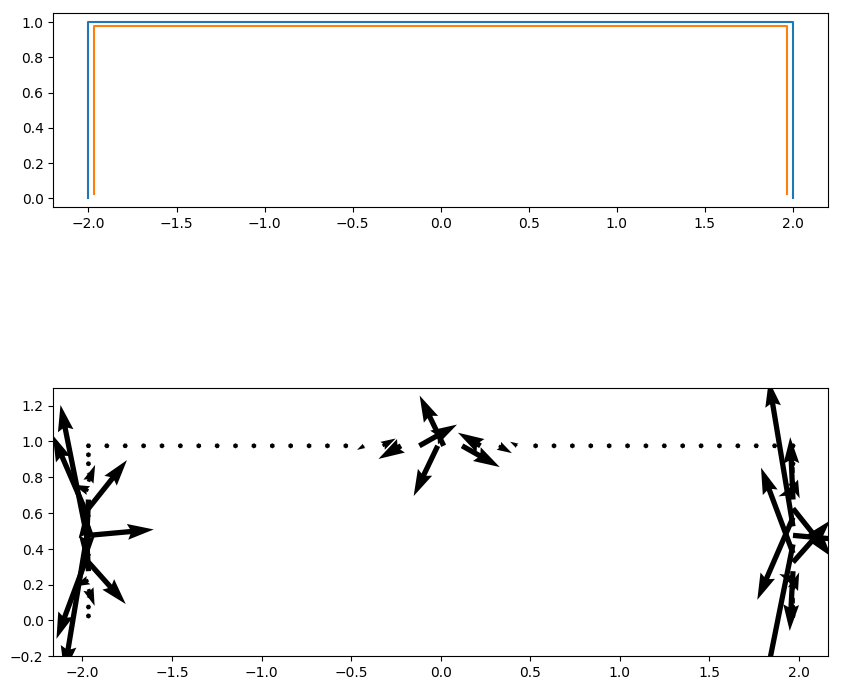

In [12]:
# translation
revolve_obj.set_rigid_velocity(np.array((0, 0, 1, 0, 0, 0)))
problem.create_F_U()
problem.solve()
if problem_kwargs['pickProblem']:
    problem.pickmyself('%s_tran' % fileHandle, pick_M=False, mat_destroy=False)
PETSc.Sys.Print('translational resistance is %f ' %
                (revolve_obj.get_total_force()[2]))
problem.vtk_obj('%s_tran' % fileHandle)

center = revolve_obj.get_u_geo().get_origin()
fnodes = revolve_obj.get_f_nodes()
rf = np.vstack((fnodes[:, 0], fnodes[:, 0], fnodes[:, 0],)).T
f = revolve_obj.get_force().reshape((-1, revolve_obj.get_n_unknown())) * rf
r = revolve_obj.get_f_geo().get_nodes() - center
t = np.cross(r, f[:, :3])  # some solve methods may have additional degrees of freedoms.
f_t = np.hstack((f, t)).sum(axis=0) * 2 * np.pi
print(f_t)


%matplotlib inline
tfct = 0.0001
tf = revolve_obj.get_force().reshape((-1, 3)).T
tu = revolve_obj.get_velocity().reshape((-1, 3)).T
tfn = revolve_obj.get_f_nodes().T
tun = revolve_obj.get_u_nodes().T

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 10), dpi=100)
fig.patch.set_facecolor('white')
axi = axs[0]
axi.plot(tun[2], tun[0])
axi.plot(tfn[2], tfn[0])
axi.set_aspect('equal', 'box')
# axi.set_xlim(0, 1)
axi = axs[1]
axi.quiver(tfn[2], tfn[0], tf[2]*tfct, tf[0]*tfct, scale = 1., units='width')
axi.set_aspect('equal', 'box')
axi.set_ylim(-0.2, 1.3)